<a href="https://colab.research.google.com/github/DanielCC-1998/Google-Colab/blob/master/Ataque_adversario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np

In [0]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [0]:
iv3 = InceptionV3()


In [0]:
print(iv3.summary())

In [0]:
from keras.preprocessing import image
from google.colab import files

#x = files.upload()

In [0]:
#vamos a hacer que la imagen tenga un tamaño de 299 x 299
y = image.img_to_array(image.load_img("hacked.png", target_size = (299,299)))
#el rango de intensidad va de 1 a -1 asi que tenemos que editarlo aqui tambien
y /= 255
y -= 0.5
y *= 2

# podemos ver el valor de y en forma matricial
#print(y)
# vemos todas las dimensiones de la imagen, siendo la ultima aquella que indica
# nuestra base, es decir rgb
print(y.shape)
# el modelo nos pide una dimension mas donde debemos indicar que cantidad de 
# imagenes vamos a pasarle de una sola pasada
y = y.reshape([1, y.shape[0], y.shape[1], y.shape[2]])
# predecimos la imagen "llama"
z = iv3.predict(y)
# esto de aqui es el vector con las 1000 probabilidades de que sea una imagen
# u otra
z.shape
# decodificamos nuestra prediccion a algo entendible
decode_predictions(z)

(299, 299, 3)


[[('n07749582', 'lemon', 0.87321025),
  ('n07747607', 'orange', 0.028368337),
  ('n02007558', 'flamingo', 0.0086206505),
  ('n07753113', 'fig', 0.0070260265),
  ('n07720875', 'bell_pepper', 0.0054298905)]]

**Ataque adversario**

---

Objetivo, manipular una imagen de forma invisible al ojo humano pero que haga que la red neuronal InceptionV3 falle, para ello NO MODIFICAMOS EL MODELO, lo que modificaremos seran los datos de entrada o pixeles, que nos permita petar la red sin siquiera saber como esta implementada

In [0]:
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

# esta clase es la clase limon
target_class = 951

# obtenemos la probabilidad (solo nos interesa el tipo de dato)
loss = out_layer [0, target_class] 

# obtenemos tipo gradiente (lo que modificar la imagen), y en este caso solo
# nos interesa el dato igual que antes
grad = K.gradients(loss, inp_layer)[0]

# declaramos la funcion donde le especificamos que le vamos a pasar de entrada
# y que datos queremos de salida, siendo learning_phase para indicar si estamos
# aprendiendo o en modo prueba
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])

# hacemos copia para consevrar la original
adv = np.copy(y)

# establecemos una perturbacion maxima (para que no se le vaya de las manos)
# y pinte todo de color amarillo con tal de ver un jodido limon
pert = 0.01

max_pert = y + 0.01
min_pert = y - 0.01

cost = 0.0

while cost < 0.95:
  
  # obtenemos tanto el gradiente (lo que se ha modificado)
  # como la nueva probabilidad
  gr, cost = optimize_gradient([adv, 0])
  
  # la modificamos
  adv += gr
  
  # si se ha modificado de mas entonces recortamos, tanto por cambios como por
  # intensidad
  adv = np.clip(adv, min_pert, max_pert)
  adv = np.clip(adv, -1, 1)
  
  print("Target cost: ", cost)

hacked = np.copy(adv)

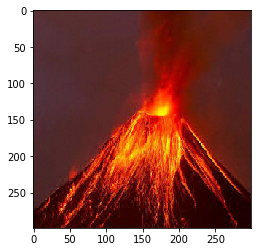

In [0]:
# para mostrar la imagen debemos recertir todo el proceso
# que hemos hecho antes de modificar la imagen
adv /= 2
adv += 0.5
adv *= 255
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [0]:
# solo la estoy guardando para poder reutilizarla mas tarde y comprobar
# si engaña o no al modelo
from PIL import Image
im = Image.fromarray(adv[0].astype(np.uint8))
im.save("./hacked.png")

# **NOTA**


---

Este ataque adversario es muy endeble, con lo cual para que no se pierdan las intensidades modificadas (ya que si lo hacen el modelo sera capaz de volver a identificar la imagen correctamente) debemos guardar esta imagen como .png y no .jpg

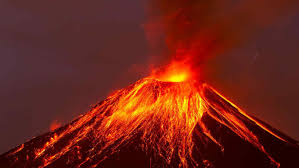

In [0]:
from IPython.display import Image
Image("volcan.jpg", width = 250, height = 250)